In [ ]:
%pip install pandas==1.5.1
%pip install torchmetrics
%pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 7.6 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 9.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 830 kB 6.7 MB/s 
     |████████████████████████████████| 280 kB 72.5 MB/s 
     |████████████████████████████████| 1.6 MB 54.8 MB/s 
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16321 sha256=35614d8f9cacbed4052138ba223c18b3dc32223f419c595fdcaa98cc5bebc912
  Stored in directory: /root/.cache/pip/wheels/08/66/b4/921e351e63d88696932279d6163e125727c9da70ed8ca38419
Succ

In [ ]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
import swifter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from matplotlib import image as mpimg
import re
from PIL import Image
import glob
import os
import pandas as pd
from torchmetrics import TweedieDevianceScore
sns.set_style('whitegrid')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 14 16:53:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    55W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Helpful functions 

In [ ]:
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error as MSE
def custom_poisson_deviance(y_true,y_pred):
  prediction=y_pred.copy()
  prediction[np.where(prediction<=0)]=10**(-10)
  return mean_poisson_deviance(y_true,prediction)

def correct_pred(pred):
  return nn.ReLU()(pred)+10**(-10)

def check_corrupted(Path):
  try: 
    Image.open(Path)
    return 0
  except:
    return 1

def get_size(path):
  image=Image.open(path)
  return np.array(image).shape

def RGB(dimension):
  try: 
    return dimension[2]==3
  except:
    return False



In [ ]:
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset

def random_split(dataset, lengths,
                 generator=default_generator):
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-t/ype]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

# Setting up data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH='/content/drive/MyDrive/Data/'
IMAGE_FOLDER='Images/'

In [ ]:
with open(PATH+"listings.pkl", "rb") as fh:
    data = pickle.load(fh)
with open(PATH+"test_listings_image.pkl", "rb") as fh:
    data_test = pickle.load(fh)
with open(PATH+"test_listings_overall.pkl", "rb") as fh:
    data_test_overall = pickle.load(fh)

# Creating dataset with filenames, id and preprocessing

In [ ]:
'''

from zipfile import ZipFile 
with ZipFile(PATH+'Images.zip', 'r') as zipfile:
    # printing all the contents of the zip file
    #zipfile.printdir()
    # extracting all the files
    print('Extracting all the files now...')
    zipfile.extractall(PATH)
    print('Done!')
'''
print('')  

In [ ]:
img_files = glob.glob(PATH+IMAGE_FOLDER+ "/*")

In [ ]:
list_ids=[img_file.replace(PATH+IMAGE_FOLDER,"") for img_file in img_files]
print('There are ',len(list_ids),' differents property reference ids in the image dataset')

There are  5882  differents property reference ids in the image dataset


In [ ]:
data_ids=data['Property Reference Id'].to_list()
data_test_ids=data_test['Property Reference Id'].to_list()
print('There are ',len(set(data_ids)),' differents property reference ids in the general dataset')
print('There are ',len(set(data_test_ids)),' differents property reference ids in the test dataset')

There are  14699  differents property reference ids in the general dataset
There are  8425  differents property reference ids in the test dataset


In [ ]:
print('There are ',len(set(list_ids)-set(data_ids)),' property reference ids in the image dataset but not in the general dataset')
print('There are ',len(set(data_ids)-set(list_ids)),' property reference ids in the general dataset but not in the image dataset')
print('There are ',len(set(list_ids)-set(data_test_ids)),' property reference ids in the image dataset but not in the test dataset')
print('There are ',len(set(data_test_ids)-set(list_ids)),' property reference ids in the test dataset but not in the image dataset')
print('There are ',len([x for x in set(data_test_ids) if x in set(data_ids)]),'ids present both in the test and train dataset')


There are  2439  property reference ids in the image dataset but not in the general dataset
There are  11256  property reference ids in the general dataset but not in the image dataset
There are  3919  property reference ids in the image dataset but not in the test dataset
There are  6462  property reference ids in the test dataset but not in the image dataset
There are  3535 ids present both in the test and train dataset


In [ ]:
#data['Property Reference Id'].value_counts()

In [ ]:
#data[data['Property Reference Id']==data['Property Reference Id'].value_counts().index[0]]

In [ ]:
#Getting the folder corresponding to ids in both the img dataset and the general data set
list_folder_workable=[x for x in img_files if x.replace(PATH+IMAGE_FOLDER,"") in data_ids]
list_folder_workable_test=[x for x in img_files if x.replace(PATH+IMAGE_FOLDER,"") in data_test_ids]
list_id_workable=[x.replace(PATH+IMAGE_FOLDER,"") for x in img_files if x.replace(PATH+IMAGE_FOLDER,"") in data_ids]
list_id_workable_test=[x.replace(PATH+IMAGE_FOLDER,"") for x in img_files if x.replace(PATH+IMAGE_FOLDER,"") in data_test_ids]
print('train:',len(list_id_workable),'test:',len(list_id_workable_test))

train: 3443 test: 1963


In [ ]:
#Keeping only data for those
data_sub=data[data['Property Reference Id'].isin(list_id_workable)].drop_duplicates(subset='Property Reference Id')
data_test_sub=data_test[data_test['Property Reference Id'].isin(list_id_workable_test)]

data_sub

,Are Pets Allowed,Category Idx,Day of Advertisement Created,Day of Date Available From,Demand,Floor,Geo Canton,Geo City,Geo Zip,Has Balcony,...,Number of Images,Price Extra Normalized,Price Gross Normalized,Price M2 Normalized,Price Net Normalized,Property Reference Id,Size M2 Normalized,Subcategory En Idx,Year Built,Year Lastrenovated
1,NaN,APPT,"November 18, 2019","March 1, 2020",2.0,1.0,VD,Le Mont-sur-Lausanne,1052,NaN,...,7,120.0,1345.0,30.0,1225.0,9680.61.2071,45.0,Apartment,NaN,NaN
4,False,APPT,"November 3, 2017","August 1, 2017",3.0,0.0,FR,Bulle,1630,False,...,3,300.0,1490.0,19.0,1190.0,9270.61.7822,79.0,Apartment,NaN,NaN
21,NaN,APPT,"December 2, 2020","February 1, 2021",10.0,3.0,LU,Luzern,6015,NaN,...,9,240.0,1400.0,17.0,1160.0,7401.61.9754,82.0,Apartment,1970.0,1996.0
28,True,APPT,"November 5, 2019","November 1, 2019",5.0,2.0,SH,Schaffhausen,8200,NaN,...,10,240.0,1990.0,17.0,1750.0,2023.50.5664,120.0,Apartment,2013.0,2013.0
38,True,APPT,"December 10, 2019","March 1, 2020",2.0,1.0,FR,Fribourg,1700,NaN,...,12,380.0,1890.0,17.0,1510.0,7468.61.4593,114.0,Apartment,1990.0,1990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19960,NaN,APPT,"June 14, 2021","September 1, 2021",0.0,2.0,NE,Boudry,2017,NaN,...,4,305.0,2050.0,20.0,1745.0,7193.26.3101,102.0,Apartment,2013.0,2013.0
19976,NaN,APPT,"January 17, 2019","April 1, 2019",13.0,0.0,ZG,Zug,6300,NaN,...,7,280.0,3080.0,25.0,2800.0,8994.68.7822,124.0,Apartment,NaN,NaN
19978,NaN,APPT,"September 9, 2020","June 16, 2019",2.0,2.0,BL,Ettingen,4107,NaN,...,11,320.0,1880.0,20.0,1560.0,7760.61.4266,96.0,Apartment,1982.0,1999.0
19981,True,APPT,"March 1, 2022","April 1, 2022",46.0,0.0,BS,Basel,4053,NaN,...,5,100.0,880.0,28.0,780.0,9970.50.7409,32.0,Apartment,1969.0,2000.0


In [ ]:
def image_plot(path):
  files=glob.glob(path+ "/*")
  n_files=len(files)
  print('There are ',n_files,' images for this id')
  #f, axarr = plt.subplots(n_files,1) 
  for i,file in enumerate(files):
    #image = mpimg.imread(file) also works btw
    image=Image.open(file)
    print(np.array(image).shape)
    plt.imshow(image)
    plt.show()
    #plt.imshow(image.transpose(Image.ROTATE_90))
    #plt.show()
    #plt.imshow(image.transpose(Image.FLIP_LEFT_RIGHT)) 
    #plt.show()
    #axarr[i].imshow(image)
  #plt.show()

There are  42  images for this id
(400, 600, 3)


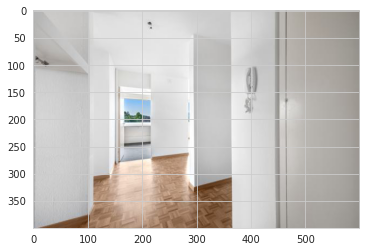

(400, 600, 3)


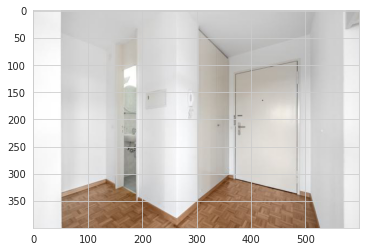

(400, 600, 3)


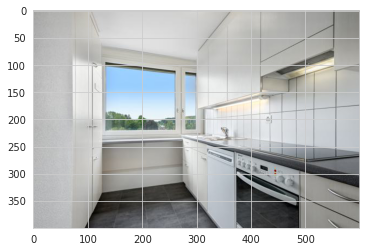

(400, 600, 3)


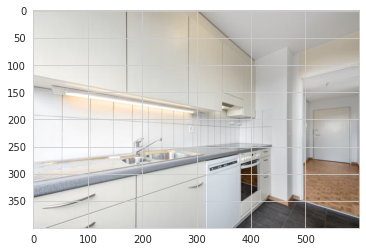

(400, 600, 3)


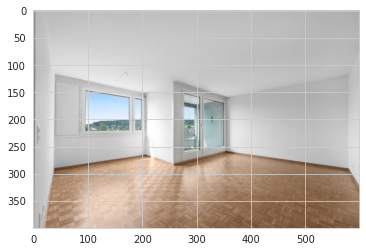

(400, 600, 3)


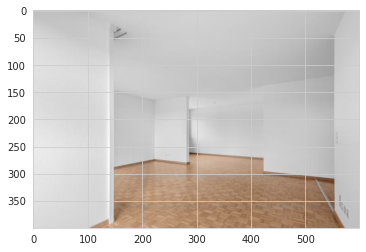

(400, 600, 3)


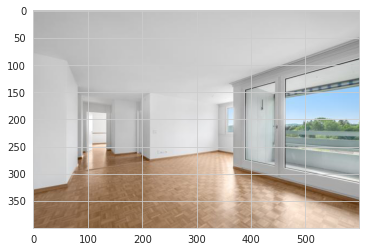

(400, 600, 3)


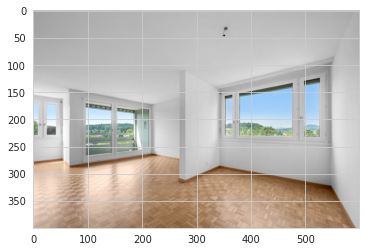

(400, 600, 3)


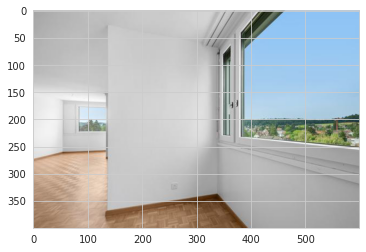

(400, 600, 3)


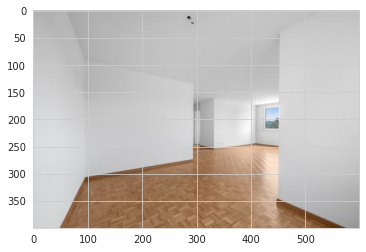

(400, 600, 3)


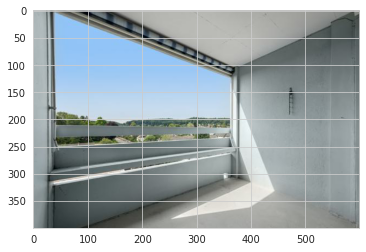

(400, 600, 3)


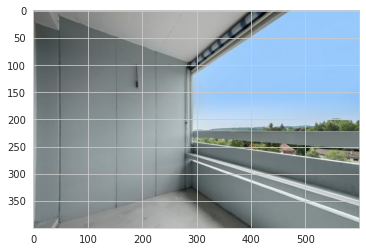

(400, 600, 3)


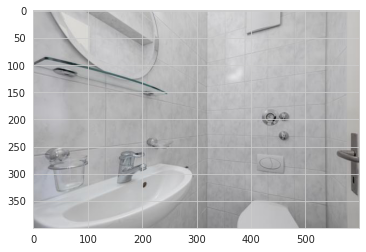

(400, 600, 3)


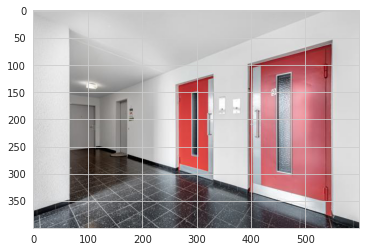

(400, 600, 3)


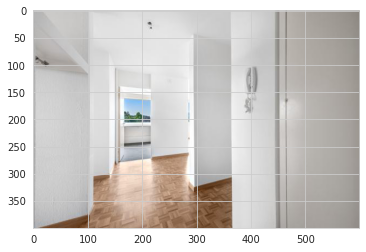

(400, 600, 3)


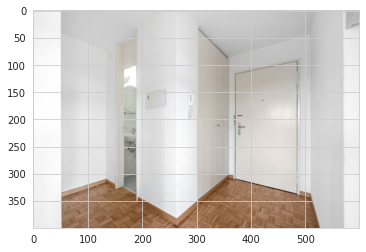

(400, 600, 3)


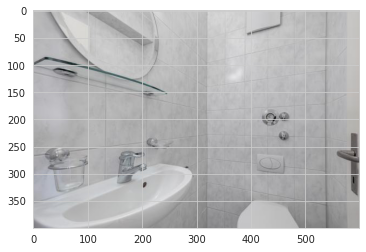

(400, 600, 3)


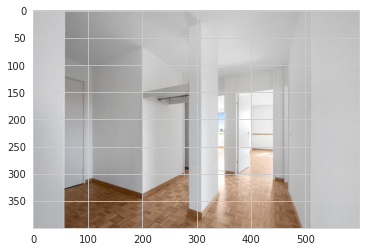

(400, 600, 3)


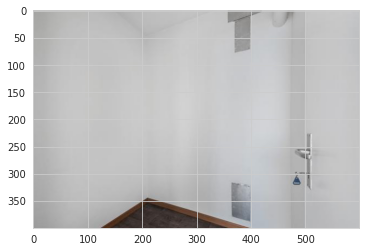

(400, 600, 3)


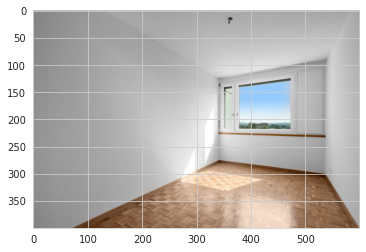

(400, 600, 3)


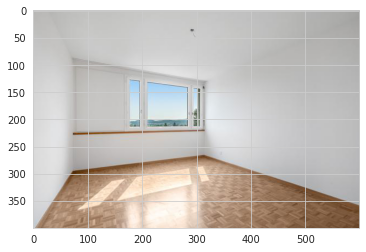

(400, 600, 3)


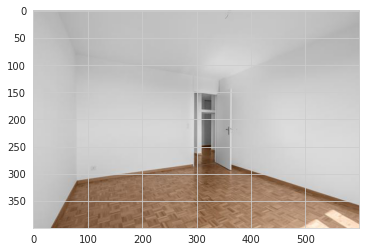

(400, 600, 3)


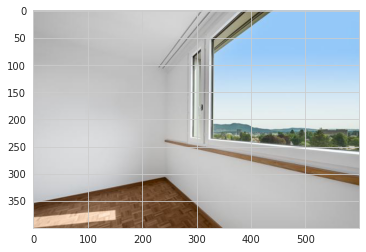

(400, 600, 3)


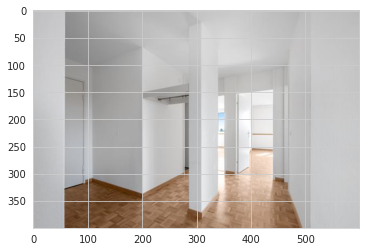

(400, 600, 3)


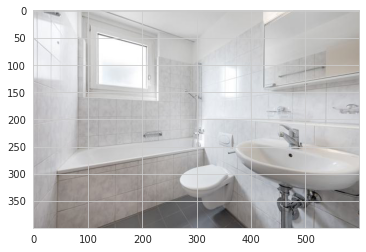

(400, 600, 3)


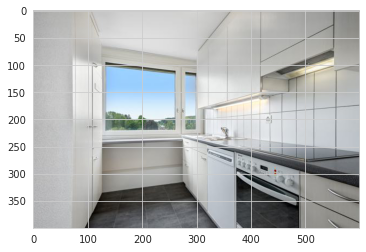

(400, 600, 3)


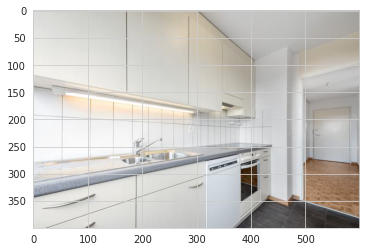

(400, 600, 3)


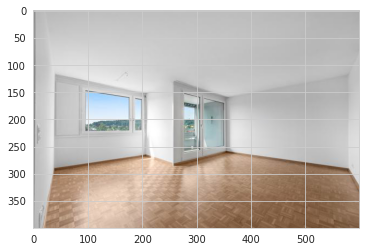

(400, 600, 3)


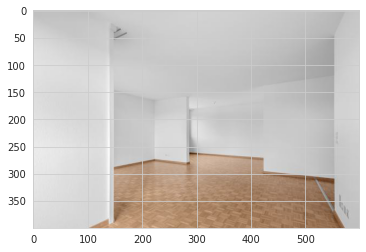

(400, 600, 3)


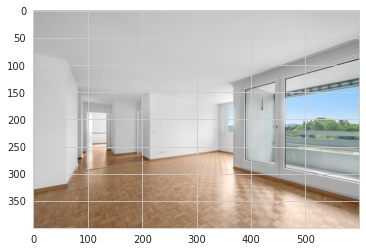

(400, 600, 3)


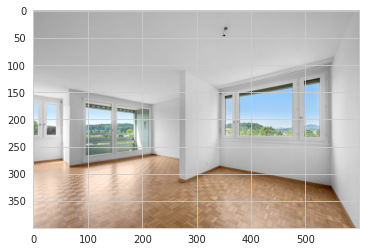

(400, 600, 3)


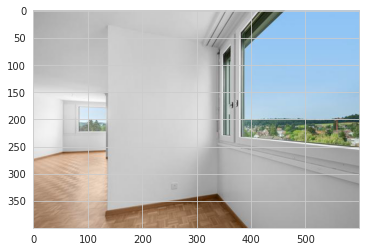

(400, 600, 3)


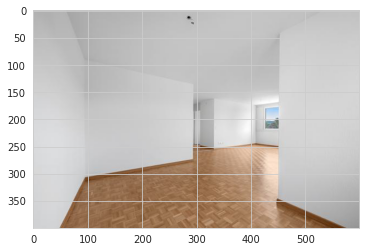

(400, 600, 3)


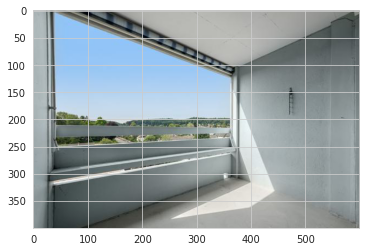

(400, 600, 3)


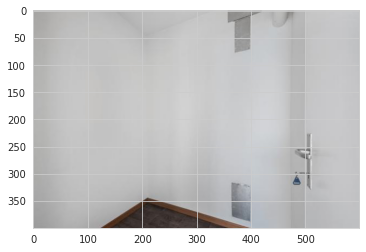

(400, 600, 3)


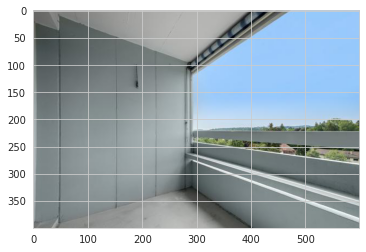

(400, 600, 3)


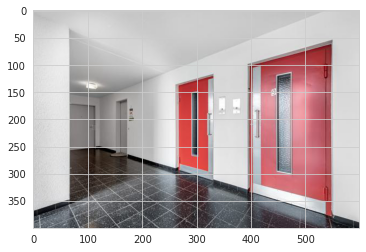

(400, 600, 3)


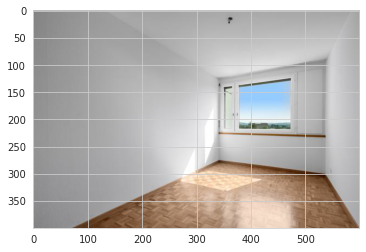

(400, 600, 3)


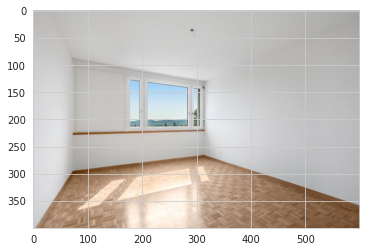

(400, 600, 3)


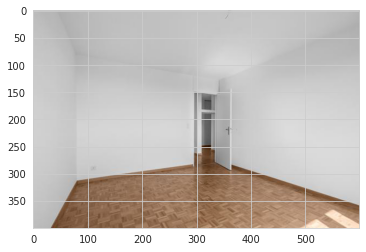

(400, 600, 3)


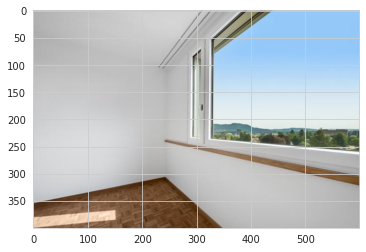

(400, 600, 3)


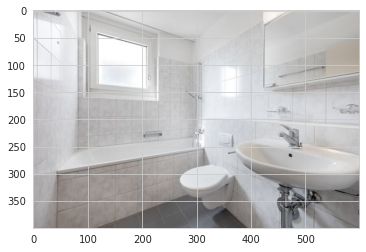

In [ ]:
image_plot(list_folder_workable[3])

In [ ]:
'''
#Creating a data set with the demand and the file name (only one image by id for now)
df=data_sub.set_index('Property Reference Id')['Demand'].to_frame()
list_list_image=[glob.glob(list_folder_workable[i]+ "/*") for i in range(len(list_folder_workable))]
list_image=[item for sublist in list_list_image for item in sublist]
temp_list=[[list_image[i].replace(PATH+'Images/',"").replace(PATH+IMAGE_FOLDER,"")[:12],
                 list_image[i]]for i in range(0,len(list_image))]

df_filename=pd.DataFrame(temp_list).rename(columns={ 0: "Property Reference Id",1:'File Name'})

data_file=df_filename.join(df,on='Property Reference Id')
data_file['Corrupted']=data_file['File Name'].apply(lambda x:check_corrupted(x))
data_file=data_file[data_file['Corrupted']==0]
data_file['Demand']=data_file['Demand'].astype('float32')
data_file['Size']=data_file['File Name'].apply(lambda x: get_size(x))
data_file['RGB']=data_file['Size'].apply(lambda x: RGB(x))
data_file=data_file[data_file['RGB']==True]
data_file.to_pickle(PATH+'data.pkl')
data_file
'''
print('')

In [ ]:
#Creating a data set with the demand and the file name for the test set
df=data_test_sub.set_index('Property Reference Id')['Prediction'].to_frame()
list_list_image=[glob.glob(list_folder_workable_test[i]+ "/*") for i in range(len(list_folder_workable_test))]
list_image=[item for sublist in list_list_image for item in sublist]
temp_list=[[list_image[i].replace(PATH+'Images/',"").replace(PATH+IMAGE_FOLDER,"")[:12],
                 list_image[i]]for i in range(0,len(list_image))]

df_filename=pd.DataFrame(temp_list).rename(columns={ 0: "Property Reference Id",1:'File Name'})

data_file=df_filename.join(df,on='Property Reference Id')

In [ ]:
data_file=data_file.reset_index(drop=True)

In [ ]:
data_file['Corrupted'] = data_file['File Name'].swifter.apply(lambda x:check_corrupted(x))

Pandas Apply:   0%|          | 0/21190 [00:00<?, ?it/s]

In [ ]:

data_file=data_file[data_file['Corrupted']==0]


In [ ]:
data_file['Size']=data_file['File Name'].swifter.apply(lambda x: get_size(x))

Pandas Apply:   0%|          | 0/21176 [00:00<?, ?it/s]

In [ ]:
data_file['RGB']=data_file['Size'].swifter.apply(lambda x: RGB(x))
data_file=data_file[data_file['RGB']==True]

Pandas Apply:   0%|          | 0/21176 [00:00<?, ?it/s]

In [ ]:
#data_file.to_pickle(PATH+'data_test.pkl')

In [ ]:
data_file

,Property Reference Id,File Name,Prediction,Corrupted,Size,RGB
0,8341.61.6570,/content/drive/MyDrive/Data/Images/8341.61.657...,NaN,0,"(400, 600, 3)",True
1,8341.61.6570,/content/drive/MyDrive/Data/Images/8341.61.657...,NaN,0,"(400, 600, 3)",True
2,8341.61.6570,/content/drive/MyDrive/Data/Images/8341.61.657...,NaN,0,"(400, 600, 3)",True
3,8341.61.6570,/content/drive/MyDrive/Data/Images/8341.61.657...,NaN,0,"(401, 600, 3)",True
4,8341.61.6570,/content/drive/MyDrive/Data/Images/8341.61.657...,NaN,0,"(401, 600, 3)",True
...,...,...,...,...,...,...
21185,1926.61.5829,/content/drive/MyDrive/Data/Images/1926.61.582...,NaN,0,"(600, 450, 3)",True
21186,1926.61.5829,/content/drive/MyDrive/Data/Images/1926.61.582...,NaN,0,"(450, 600, 3)",True
21187,1926.61.5829,/content/drive/MyDrive/Data/Images/1926.61.582...,NaN,0,"(600, 450, 3)",True
21188,1926.61.5829,/content/drive/MyDrive/Data/Images/1926.61.582...,NaN,0,"(600, 450, 3)",True


In [ ]:
#Creating a data set with the demand and the file name for the test set
df=data_test_sub.set_index('Property Reference Id')['Prediction'].to_frame()
list_list_image=[glob.glob(list_folder_workable_test[i]+ "/*") for i in range(len(list_folder_workable_test))]
list_image=[item for sublist in list_list_image for item in sublist]
temp_list=[[list_image[i].replace(PATH+'Images/',"").replace(PATH+IMAGE_FOLDER,"")[:12],
                 list_image[i]]for i in range(0,len(list_image))]

df_filename=pd.DataFrame(temp_list).rename(columns={ 0: "Property Reference Id",1:'File Name'})

data_file=df_filename.join(df,on='Property Reference Id')

data_file['Corrupted']=data_file['File Name'].apply(lambda x:check_corrupted(x))
data_file=data_file[data_file['Corrupted']==0]

data_file['Size']=data_file['File Name'].apply(lambda x: get_size(x))
data_file['RGB']=data_file['Size'].apply(lambda x: RGB(x))
data_file=data_file[data_file['RGB']==True]
data_file.to_pickle(PATH+'data_test.pkl')
data_file



# Creating a dataset class with the images

In [ ]:
data_file=pd.read_pickle(PATH+'data.pkl')
data_file_pred=pd.read_pickle(PATH+'data_test.pkl')
data_file_pred=data_file_pred.rename(columns={'Prediction':'Demand'})
data_file

,Property Reference Id,File Name,Demand,Corrupted,Size,RGB
0,0002.61.6915,/content/drive/MyDrive/Data/Images/0002.61.691...,2.0,0,"(400, 600, 3)",True
1,0002.61.6915,/content/drive/MyDrive/Data/Images/0002.61.691...,2.0,0,"(400, 600, 3)",True
2,0002.61.6915,/content/drive/MyDrive/Data/Images/0002.61.691...,2.0,0,"(400, 600, 3)",True
3,0002.68.7685,/content/drive/MyDrive/Data/Images/0002.68.768...,1.0,0,"(400, 600, 3)",True
4,0002.68.7685,/content/drive/MyDrive/Data/Images/0002.68.768...,1.0,0,"(400, 600, 3)",True
...,...,...,...,...,...,...
29214,9995.61.8658,/content/drive/MyDrive/Data/Images/9995.61.865...,1.0,0,"(400, 600, 3)",True
29215,9995.61.8658,/content/drive/MyDrive/Data/Images/9995.61.865...,1.0,0,"(400, 600, 3)",True
29216,9995.61.8658,/content/drive/MyDrive/Data/Images/9995.61.865...,1.0,0,"(400, 600, 3)",True
29217,9995.61.8658,/content/drive/MyDrive/Data/Images/9995.61.865...,1.0,0,"(400, 600, 3)",True


In [ ]:
#Splitting the ids for train and test set
import random
import math
unique_ids=data_file['Property Reference Id'].unique()
ids_train=np.array(random.sample(set(unique_ids), math.floor(0.8*len(unique_ids))))
ids_test=np.array([x for x in unique_ids if x not in ids_train])
print(len(unique_ids),len(ids_train),len(ids_test))


3427 2741 686


In [ ]:
data_file_train=data_file[data_file['Property Reference Id'].isin(ids_train)]
data_file_test=data_file[data_file['Property Reference Id'].isin(ids_test)]
print(len(data_file),len(data_file_train),len(data_file_test))

29182 23252 5930


In [ ]:
#def collate_fn(self, batch):
#    batch = list(filter(lambda x: x is not None, batch))
#    return torch.utils.data.dataloader.default_collate(batch)


class MyCustomDataset(Dataset):
  def __init__(self,df,img_dir,transform=None):
    self.img_dir=img_dir
    self.img_id=df['File Name'].to_frame()
    self.y=df['Demand'].to_frame()
    self.id=df['Property Reference Id'].to_frame()
    self.transform=transform

  def __getitem__(self,index):
    img=Image.open(os.path.join(self.img_dir,self.img_id.iloc[index]['File Name']))
    if self.transform:
      img=self.transform(img)
    #Have uniform orientation (should be done in transform?)
    #if np.array(img).shape[0]<np.array(img).shape[1]:
    #  img=img.transpose(Image.ROTATE_90)
    label=torch.tensor(self.y.iloc[index]['Demand']
    #                   ,dtype=torch.float32
                       )
    id=self.id.iloc[index]['Property Reference Id']
    return img,label,id

  def __len__(self):
    return self.y.shape[0]





In [ ]:
#We work with square image for now
img_size=(224,224)
resize_transformer=transforms.Resize(img_size)
transformer=transforms.Compose([resize_transformer,
                                transforms.ToTensor(),transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

#transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))?

Demand: tensor(1.)
Id: 0002.68.7685


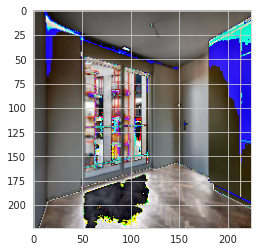

In [ ]:
dataset_train=MyCustomDataset(data_file_train,PATH+IMAGE_FOLDER,transform=transformer)
sample=dataset_train[3]
print('Demand:', sample[1])
print('Id:',sample[2])
plt.imshow(transforms.ToPILImage()(sample[0]))
plt.show()

Demand: tensor(3.)
Id: 0043.61.6658


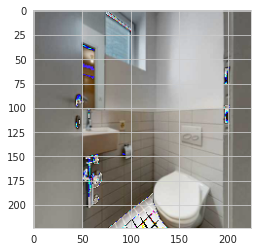

In [ ]:
dataset_test=MyCustomDataset(data_file_test,PATH+IMAGE_FOLDER,transform=transformer)
sample=dataset_test[3]
print('Demand:', sample[1])
print('Id:',sample[2])
plt.imshow(transforms.ToPILImage()(sample[0]))
plt.show()

Demand: tensor(3.)
Id: 0043.61.6658


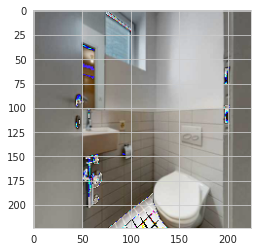

In [ ]:
dataset_pred=MyCustomDataset(data_file_pred,PATH+IMAGE_FOLDER,transform=transformer)
sample=dataset_test[3]
print('Demand:', sample[1])
print('Id:',sample[2])
plt.imshow(transforms.ToPILImage()(sample[0]))
plt.show()

In [ ]:
batch_size=64
#train_set,test_set=random_split(dataset, lengths=[0.8,0.2])
train_loader=DataLoader(dataset=dataset_train,batch_size=batch_size,drop_last=True,shuffle=True,pin_memory=torch.cuda.is_available(),num_workers=10)
test_loader=DataLoader(dataset=dataset_test,batch_size=batch_size,pin_memory=torch.cuda.is_available(),num_workers=10)

In [ ]:
#data_file['Img Size']=data_file['File Name'].apply(lambda x:np.array(Image.open(x)).shape)
#data_file['Img Size'].value_counts()

# Defining the model

In [ ]:
#CNN Network
class ConvNet(nn.Module):
  def __init__(self,img_size=img_size,dim_output=1):
    super(ConvNet,self).__init__()

    #Output size after convolution filter:
    #((width-kernel_size+2Padding)/stride)+1
    
    #Default Input shape (batch_size,num_channel,img_size[0],img_size[1])=(4,3,150,150)
    
    self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1,padding=2,bias=False)
    #Shape=(4,12,150,150)
    self.bn1=nn.BatchNorm2d(num_features=16)
    #Shape=(4,12,150,150)
    self.relu1=nn.ReLU()
    #Shape=(4,12,150,150)

    self.pool1=nn.MaxPool2d(kernel_size=2)
    #Reduce the image size by a factor 2
    #Shape=(4,12,75,75)

    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=2,bias=False)
    #Shape=(4,20,75,75)
    self.bn2=nn.BatchNorm2d(num_features=32)
    #Shape=(4,20,75,75)
    self.relu2=nn.ReLU()
    #Shape=(4,20,75,75)

    self.pool2=nn.MaxPool2d(kernel_size=2)

    self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=2,bias=False)
    #Shape=(4,20,75,75)
    self.bn3=nn.BatchNorm2d(num_features=64)
    #Shape=(4,20,75,75)
    self.relu3=nn.ReLU()
    #Shape=(4,20,75,75)

    self.pool3=nn.MaxPool2d(kernel_size=2)

    
    self.fc1=nn.Linear(in_features=64*28*28,out_features=16)
    self.bn4=nn.BatchNorm1d(num_features=16)
    self.dropout1=torch.nn.Dropout()
    #self.relu4=nn.ReLU()
    
    self.fc2=nn.Linear(in_features=16,out_features=4)
    #self.relu5=nn.ReLU()
    
    self.fc3=nn.Linear(in_features=4,out_features=1)

  #Feed forward function:

  def forward(self,input):
    output=self.conv1(input)
    output=self.bn1(output)
    output=self.relu1(output)

    output=self.pool1(output)

    output=self.conv2(output)
    output=self.bn2(output)
    output=self.relu2(output)
    output=self.pool2(output)

    output=self.conv3(output)
    output=self.bn3(output)
    output=self.relu3(output)

    output=self.pool3(output)

    #Above output will be in matrix form with shape (4,20,75,75)

    output=output.view(-1,64*28*28)
    output=self.fc1(output)
    output=self.bn4(output)
    #output=self.relu4(output)
    output=self.dropout1(output)

    output=self.fc2(output)
    #output=self.relu5(output)
    
    output=self.fc3(output)
    return output



In [ ]:
#Function to compute mse and mdp on test set 
@torch.no_grad()
def validate_loss(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    list_output=[]
    list_target=[]
    list_ids=[]
    for data, target, id in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        list_output.append(output)
        list_target.append(target)
        list_ids.append(id)
        test_loss += criterion(output, target.view_as(output)).item() * len(data)
   
    test_loss /= len(val_loader.dataset)

    outputs=[item for sublist in list_output for item in sublist]
    outputs_values=np.array([x.item() for x in outputs])
    outputs_values[np.where(outputs_values<=0)]=10**(-10)
    targets=[item for sublist in list_target for item in sublist]
    targets_values=np.array([x.item() for x in targets])
    id_values=np.array([item for sublist in list_ids for item in sublist])
    
    MPD=custom_poisson_deviance(targets_values,outputs_values)
    Mse=MSE(targets_values,outputs_values)
    #print('Test set: Mean Poisson Deviance: ',MPD,'MSE: ',Mse)

    return MPD,Mse


# Model Training

Epoch 0 Batch 0 Train MSE 56.00675964355469 Test MSE 107.91488268439004 Test MPD 245.65382428048355
Epoch 0 Batch 100 Train MSE 75.7817153930664 Test MSE 81.71725274022077 Test MPD 8.79156685793413
Epoch 0 Batch 200 Train MSE 47.799407958984375 Test MSE 84.43376830991707 Test MPD 9.36930017969695
Epoch 0 Batch 300 Train MSE 159.9951934814453 Test MSE 81.63358301932317 Test MPD 8.749163970048082
Epoch 1 Batch 0 Train MSE 46.0574836730957 Test MSE 104.35144094695269 Test MPD 108.53397269692952
Epoch 1 Batch 100 Train MSE 22.473773956298828 Test MSE 82.10779299306151 Test MPD 8.845554824323852
Epoch 1 Batch 200 Train MSE 14.071474075317383 Test MSE 82.04207314155245 Test MPD 8.823004635522391
Epoch 1 Batch 300 Train MSE 66.89015197753906 Test MSE 81.62906666302729 Test MPD 8.735662036260614
Epoch 2 Batch 0 Train MSE 94.34626770019531 Test MSE 85.2110408352679 Test MPD 9.658714021518401
Epoch 2 Batch 100 Train MSE 18.480680465698242 Test MSE 82.12871087126115 Test MPD 8.832435495804763
Epo

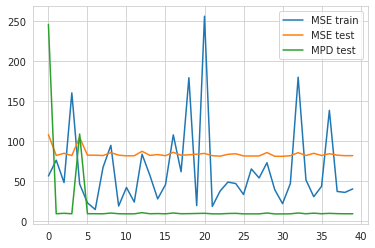

In [ ]:
model=ConvNet(img_size).to(device)
#Optimizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=torch.nn.MSELoss()

#loss_function=torch.nn.PoissonNLLLoss()
num_epochs=10
mse_history_train=[]
mse_history_test=[]
mpd_history_test=[]
for epoch in range(num_epochs):
  model.train()
  
  for i, (images,labels,ids) in enumerate(train_loader):
    if torch.cuda.is_available():
      images=Variable(images.to(device))
      labels=Variable(labels.to(device))
  
    
    #optimizer.zero_grad()
    for param in model.parameters():
      param.grad = None

    output=model(images)
    loss=loss_function(output,labels.view_as(output))
    loss.backward()
    optimizer.step()
    #print('Batch',i)
    if i %100==0:
      #print('Epoch',epoch,'Batch',i,'Train MSE',loss.item())
      mse_history_train.append(loss.item())
      MPD,Mse=validate_loss(model,device,test_loader,loss_function)
      print('Epoch',epoch,'Batch',i,'Train MSE',loss.item(),'Test MSE',Mse,'Test MPD',MPD)
      mse_history_test.append(Mse)
      mpd_history_test.append(MPD)
      
'''
  #For each epoch store the loss
  mse_history_train.append(loss.item())
  MPD,Mse=validate_loss(model,device,test_loader,loss_function)
  print('Epoch',epoch,'Train MSE',loss.item(),'Test MPD:', MPD,'Test MSE', Mse)
  mse_history_test.append(Mse)
  mpd_history_test.append(MPD)
'''
plt.plot(mse_history_train,label='MSE train')
plt.plot(mse_history_test,label='MSE test')
plt.plot(mpd_history_test,label='MPD test')
plt.legend()
plt.show()

    

# Evaluating the model

In [ ]:
@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    list_output=[]
    list_target=[]
    list_ids=[]
    for data, target, id in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        list_output.append(output)
        list_target.append(target)
        list_ids.append(id)
        test_loss += criterion(output, target.view_as(output)).item() * len(data)
   
    test_loss /= len(val_loader.dataset)

    outputs=[item for sublist in list_output for item in sublist]
    outputs_values=np.array([x.item() for x in outputs])
    outputs_values[np.where(outputs_values<=0)]=10**(-10)
    targets=[item for sublist in list_target for item in sublist]
    targets_values=np.array([x.item() for x in targets])
    id_values=np.array([item for sublist in list_ids for item in sublist])
    
    print('Mean Poisson Deviance: ',custom_poisson_deviance(targets_values,outputs_values),'MSE: ',
    MSE(targets_values,outputs_values))

    return outputs_values,targets_values, id_values 


In [ ]:
#torch.save(model, PATH+'model2.pkl')

In [ ]:
#Checking results on test set
outputs, targets,ids =validate(model,device,val_loader=test_loader,criterion=loss_function)
temp_df=pd.DataFrame(np.array([ids,outputs,targets]).T,columns=['Ids','Predictions','Target'])
display(temp_df)


Mean Poisson Deviance:  8.996848360987883 MSE:  82.23738085261648


,Ids,Predictions,Target
0,0025.61.4088,2.8979108333587646,4.0
1,0025.61.4088,3.357231855392456,4.0
2,0043.61.6658,3.6519205570220947,3.0
3,0043.61.6658,3.3888375759124756,3.0
4,0043.61.6658,4.619225978851318,3.0
...,...,...,...
5834,9995.50.6571,2.8215157985687256,2.0
5835,9995.50.6571,1.919189691543579,2.0
5836,9995.50.6571,2.324223279953003,2.0
5837,9995.50.6571,3.48165225982666,2.0


In [ ]:
temp_df['Predictions']=temp_df['Predictions'].astype('float')
temp_df['Target']=temp_df['Target'].astype('float')
display(temp_df.describe())
agg_df=temp_df.groupby('Ids').mean()
display(agg_df)
print('MPD on aggregated df',custom_poisson_deviance(agg_df['Target'].to_numpy(),agg_df['Predictions'].to_numpy()))

,Predictions,Target
count,5839.000000,5839.000000
mean,3.803955,5.006508
std,1.312210,9.102964
min,0.324620,0.000000
25%,2.928824,0.000000
50%,3.542321,2.000000
75%,4.441073,6.000000
max,13.874335,74.000000


,Predictions,Target
Ids,,
0025.61.4088,3.127571,4.0
0043.61.6658,3.249023,3.0
0051.26.5766,2.776274,1.0
0051.61.6618,2.959229,1.0
0053.61.9424,3.467387,0.0
...,...,...
9880.61.4266,2.674863,12.0
9880.92.1151,3.278680,3.0
9892.26.5664,3.877501,0.0


MPD on aggregated df 8.765864957959797


In [ ]:
threshold=1
print('There are ',len(temp_df[temp_df['Predictions'].astype('float32')>threshold]),'out of ',len(temp_df), 'predictions greater than ',threshold)

There are  5831 out of  5839 predictions greater than  1


In [ ]:
#Checking results on train set
outputs, targets,ids =validate(model,device,val_loader=train_loader,criterion=loss_function)
temp_df=pd.DataFrame(np.array([ids,outputs,targets]).T,columns=['Ids','Predictions','Target'])
temp_df

In [ ]:
temp_df['Predictions']=temp_df['Predictions'].astype('float')
temp_df['Target']=temp_df['Target'].astype('float')
agg_df=temp_df.groupby('Ids').mean()
agg_df
print('MPD on aggregated df',custom_poisson_deviance(agg_df['Target'].to_numpy(),agg_df['Predictions'].to_numpy()))

,Predictions,Target
Ids,,
0002.61.6915,2.542945,2.0
0002.68.7685,2.673822,1.0
0002.92.6618,2.512250,0.0
0012.50.3101,8.906663,5.0
0012.61.4593,12.890624,7.0
...,...,...
9995.50.5829,3.270124,4.0
9995.50.6571,3.372181,2.0
9995.50.8394,3.852977,5.0


In [ ]:
custom_poisson_deviance(agg_df['Target'].to_numpy(),agg_df['Predictions'].to_numpy())

2.67342195485189

# Submitting prediction

In [ ]:
@torch.no_grad()
def pred_output(model, device, val_loader):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    list_output=[]
    list_ids=[]
    for data, target,id in val_loader:
        data = data.to(device)
        output = model(data)
        list_output.append(output)
        list_ids.append(id)

    outputs=[item for sublist in list_output for item in sublist]
    outputs_values=np.array([x.item() for x in outputs])
    outputs_values[np.where(outputs_values<=0)]=10**(-10)
    id_values=np.array([item for sublist in list_ids for item in sublist])
    
    return outputs_values,id_values 


In [ ]:
pred_loader=DataLoader(dataset=dataset_pred,batch_size=batch_size,pin_memory=torch.cuda.is_available(),num_workers=10)

In [ ]:
outputs,ids =pred_output(model,device,val_loader=pred_loader)

,Ids,Predictions
0,8341.61.6570,2.7409732341766357
1,8341.61.6570,3.0958821773529053
2,8341.61.6570,3.6627321243286133
3,8341.61.6570,2.353688955307007
4,8341.61.6570,2.5517733097076416
...,...,...
21166,1926.61.5829,3.0668461322784424
21167,1926.61.5829,4.088926792144775
21168,1926.61.5829,2.788562536239624
21169,1926.61.5829,5.271491527557373


In [ ]:
pred_df=pd.DataFrame(np.array([ids,outputs]).T,columns=['Property Reference Id','Prediction'])
pred_df['Prediction']=pred_df['Prediction'].astype('float')
display(pred_df.describe())
pred_df_agg=pred_df.groupby('Property Reference Id').mean().reset_index()

,Prediction
count,2.117100e+04
mean,3.829650e+00
std,1.318838e+00
min,1.000000e-10
25%,2.958172e+00
50%,3.566597e+00
75%,4.449728e+00
max,1.387434e+01


In [ ]:

pred_df_agg

,Property Reference Id,Prediction
0,0002.61.6915,3.777916
1,0002.68.7685,4.104436
2,0002.92.6618,3.990806
3,0011.50.6403,4.958652
4,0043.61.4593,5.389504
...,...,...
1949,9986.26.8233,4.330067
1950,9995.50.0065,5.158299
1951,9995.50.5664,3.593746
1952,9995.61.0065,5.058955


In [ ]:
submission_df=data_test['Property Reference Id'].to_frame().merge(pred_df_agg,on='Property Reference Id',how='outer')
submission_df

,Property Reference Id,Prediction
0,1796.61.7409,NaN
1,6907.26.2935,5.878267
2,6907.26.2935,5.878267
3,5010.92.5240,NaN
4,5010.92.5240,NaN
...,...,...
9995,9653.50.2878,3.423474
9996,5490.61.5834,NaN
9997,7142.22.1169,NaN
9998,4849.03.5240,NaN


In [ ]:
submission_df.to_csv(PATH+'image_prediction.csv',index=False)

In [ ]:
submission_df.isna().sum()

Property Reference Id       0
Prediction               7684
dtype: int64

In [ ]:
submission_df=pd.read_csv(PATH+'image_prediction.csv')

In [ ]:
submission_df.sort_values(by='Property Reference Id')

,Property Reference Id,Prediction
8196,0002.26.4593,NaN
3403,0002.56.2935,NaN
3404,0002.56.2935,NaN
4720,0002.56.3230,NaN
2688,0002.56.5039,NaN
...,...,...
9131,9995.50.0065,5.158299
6204,9995.50.5664,3.593746
1227,9995.61.0065,5.058955
4149,9995.61.3115,NaN


In [ ]:
agg_pred=submission_df.dropna().drop_duplicates()
agg_pred

,Property Reference Id,Prediction
1,6907.26.2935,5.878267
5,5649.50.9646,3.538333
9,7622.61.8658,4.793194
24,2416.61.7409,3.241764
25,9057.61.5834,5.440636
...,...,...
9968,8595.50.5834,4.560126
9981,4734.26.9424,3.575135
9982,3903.61.4589,3.126815
9991,9748.61.6915,5.571442


In [ ]:
submission_df2=data_test['Property Reference Id'].to_frame().merge(agg_pred,on='Property Reference Id',how='left')
submission_df2

,Property Reference Id,Prediction
0,1796.61.7409,NaN
1,6907.26.2935,5.878267
2,5010.92.5240,NaN
3,5649.50.9646,3.538333
4,9418.61.5664,NaN
...,...,...
9995,9653.50.2878,3.423474
9996,5490.61.5834,NaN
9997,7142.22.1169,NaN
9998,4849.03.5240,NaN


In [ ]:
submission_df2.to_csv(PATH+'image_prediction_ordered.csv',index=False)

In [ ]:
data_test

,Property Reference Id,Prediction
0,1796.61.7409,NaN
1,6907.26.2935,NaN
2,5010.92.5240,NaN
3,5649.50.9646,NaN
4,9418.61.5664,NaN
...,...,...
9995,9653.50.2878,NaN
9996,5490.61.5834,NaN
9997,7142.22.1169,NaN
9998,4849.03.5240,NaN


#Creating dataframe with vectorised images for the multimodal model

In [ ]:
model = torch.load(PATH+'model2.pkl')
model.eval()
model

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=16, bias=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
model.bn4.register_forward_hook(get_activation('bn4'))
list_ids=[]
list_output=[]
for i, (images,labels,ids) in enumerate(pred_loader):
  if i %10==0:
    print(i)
  if torch.cuda.is_available():
    images=Variable(images.to(device))
    labels=Variable(labels.to(device))
  activation = {}
  output = model(images)
  list_ids.append(ids)
  list_output.append(activation['bn4'])
  
outputs=[item for sublist in list_output for item in sublist]
outputs_values=np.array([x.cpu().numpy() for x in outputs])
id_values=np.array([item for sublist in list_ids for item in sublist])
print(outputs_values.shape,id_values.shape)



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
(21171, 16) (21171,)


In [ ]:
pred_vectorised=pd.concat([pd.DataFrame(id_values,columns=['Property Reference Id']),pd.DataFrame(outputs_values)],axis=1)


In [ ]:
pred_vectorised

,Property Reference Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,8341.61.6570,-0.849968,-3.240616,-3.917287,2.699605,3.116759,-3.104941,-0.207285,0.774784,3.297490,3.013693,-0.367227,-3.211585,0.591526,-0.318698,-1.845122,3.721253
1,8341.61.6570,-0.133047,-3.502283,-4.219102,3.164258,3.487994,-3.710566,-0.473542,0.992200,3.729333,3.157966,0.318890,-3.499655,0.582798,-0.804382,-2.050940,4.252655
2,8341.61.6570,1.016204,-4.104066,-5.018960,3.695715,4.281897,-4.371731,-1.065704,1.375457,4.286963,3.913172,0.700830,-4.118676,-0.227138,-1.121138,-2.716482,4.860582
3,8341.61.6570,0.114330,-2.968678,-3.761842,2.179164,2.589720,-3.011276,-2.045416,0.024885,3.092517,2.627254,-2.022895,-3.039211,-0.562394,1.104918,-1.223571,3.618255
4,8341.61.6570,-0.715925,-3.227824,-3.849418,2.405258,2.858965,-3.181899,-1.430426,0.314886,3.193606,2.833800,-1.533805,-3.292569,-0.324218,0.720005,-1.580568,3.606343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21166,1926.61.5829,0.685632,-4.020181,-4.698476,2.822384,3.578197,-4.061289,-4.121346,0.188569,4.061197,3.434967,-2.519817,-4.018798,-1.986176,1.315820,-1.878864,4.576988
21167,1926.61.5829,0.574127,-4.806489,-5.569428,4.195199,4.792581,-5.033579,-0.658546,1.354679,4.941759,4.282148,0.315689,-4.570895,0.536657,-0.821080,-2.993514,5.525500
21168,1926.61.5829,-0.749949,-3.481339,-4.220977,2.761591,2.961878,-3.360797,-1.698399,0.626296,3.436264,3.036188,-1.304290,-3.355610,0.020404,0.141869,-1.917535,3.993630
21169,1926.61.5829,0.324329,-6.065782,-6.730525,5.309654,6.473758,-6.336216,-1.905841,2.380155,6.104659,5.530360,1.604911,-5.783335,-0.297243,-2.312171,-4.473104,6.824512


In [ ]:
pred_vectorised.to_csv(PATH+'image_pred_vectorised.csv',index=False)

In [ ]:
'''
model.bn4.register_forward_hook(get_activation('bn4'))
list_ids=[]
list_target=[]
list_output=[]
for i, (images,labels,ids) in enumerate(test_loader):
  if i %10==0:
    print(i)
  if torch.cuda.is_available():
    images=Variable(images.to(device))
    labels=Variable(labels.to(device))
  activation = {}
  output = model(images)
  list_target.append(labels)
  list_ids.append(ids)
  list_output.append(activation['bn4'])
  
outputs=[item for sublist in list_output for item in sublist]
outputs_values=np.array([x.cpu().numpy() for x in outputs])
targets=[item for sublist in list_target for item in sublist]
targets_values=np.array([x.item() for x in targets])
id_values=np.array([item for sublist in list_ids for item in sublist])
print(outputs_values.shape,targets_values.shape,id_values.shape)


data_vectorised=pd.concat([pd.DataFrame(id_values,columns=['Property Reference Id']),pd.DataFrame(outputs_values),pd.DataFrame(targets_values,columns=['Demand'])],axis=1)
#data_vectorised.to_csv(PATH+'image_vectorised.csv',index=False)
'''

0
10
20
30
40
50
60
70
80
90
(5843, 16) (5843,) (5843,)
